Подключение PySpark модулей

In [1]:
import pyspark
from pyspark.rdd import RDD
from pyspark.sql import Row
from pyspark.sql import DataFrame
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql import functions as F
from pyspark.sql.functions import lit, desc, col, size, array_contains\
, isnan, udf, hour, array_min, array_max, countDistinct
from pyspark.sql.types import *

from pyspark.ml.stat import Correlation
from pyspark.mllib.stat import Statistics
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

Подключение модулей, не связанных с PySpark

In [2]:
import os
import sys
import pandas as pd
from pandas import DataFrame
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import math
from IPython.core.interactiveshell import InteractiveShell
from datetime import *
import statistics as stats
# This helps auto print out the items without explixitly using 'print'
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline

Инициализация датасета

In [6]:
MAX_MEMORY = '4G'
filename_data = 'Data/data.csv'

def init_spark():
    spark = SparkSession \
        .builder \
        .appName("Pyspark") \
        .config(conf=conf) \
        .getOrCreate()
    return spark

# Инициализация сессии спарка
conf = pyspark.SparkConf().setMaster("local[*]") \
        .set('spark.executor.heartbeatInterval', 10000) \
        .set('spark.network.timeout', 10000) \
        .set("spark.core.connection.ack.wait.timeout", "3600") \
        .set("spark.executor.memory", MAX_MEMORY) \
        .set("spark.driver.memory", MAX_MEMORY)
spark = init_spark()

# Загрузка датасета во фрейм 
df = spark.read.option("inferSchema",True) \
                 .option("delimiter",",") \
                 .option("header", True) \
                .csv(filename_data)

# Вывод типа датасета
print('Тип датафрейма: ' + str(type(df)))

# Вывод содержимого датасета
print('Содержимое датафрейма:')
df.show(truncate=10)

Тип датафрейма: <class 'pyspark.sql.dataframe.DataFrame'>
Содержимое датафрейма:
+---------+----------+-------------+-----------+----------+------------+----------+----------+----------+
|    LCLid|       day|energy_median|energy_mean|energy_max|energy_count|energy_std|energy_sum|energy_min|
+---------+----------+-------------+-----------+----------+------------+----------+----------+----------+
|MAC000002|2012-10...|       0.1385| 0.15430...|0.88599...|          46|0.19603...|7.09800...|       0.0|
|MAC000002|2012-10...|         0.18| 0.23097...|     0.933|          48|0.19232...|11.0870...|     0.076|
|MAC000002|2012-10...|        0.158| 0.27547...|     1.085|          48|0.27464...|    13.223|      0.07|
|MAC000002|2012-10...|        0.131|  0.2136875|     1.164|          48|0.22448...|    10.257|      0.07|
|MAC000002|2012-10...|        0.145| 0.20352...|     0.991|          48|0.18411...|     9.769|     0.087|
|MAC000002|2012-10...|        0.148| 0.22677...|     0.784|          48

Типы данных столбцов

In [7]:
# Вывод типов столбцов
print('Обзор данных')
df.printSchema()

Обзор данных
root
 |-- LCLid: string (nullable = true)
 |-- day: timestamp (nullable = true)
 |-- energy_median: double (nullable = true)
 |-- energy_mean: double (nullable = true)
 |-- energy_max: double (nullable = true)
 |-- energy_count: integer (nullable = true)
 |-- energy_std: double (nullable = true)
 |-- energy_sum: double (nullable = true)
 |-- energy_min: double (nullable = true)



In [ ]:
Избавляемся от столбцов

In [9]:
# Вывод типов столбцов
df = df.drop("LCLid", "day")
df.show(truncate=10)

+-------------+-----------+----------+------------+----------+----------+----------+
|energy_median|energy_mean|energy_max|energy_count|energy_std|energy_sum|energy_min|
+-------------+-----------+----------+------------+----------+----------+----------+
|       0.1385| 0.15430...|0.88599...|          46|0.19603...|7.09800...|       0.0|
|         0.18| 0.23097...|     0.933|          48|0.19232...|11.0870...|     0.076|
|        0.158| 0.27547...|     1.085|          48|0.27464...|    13.223|      0.07|
|        0.131|  0.2136875|     1.164|          48|0.22448...|    10.257|      0.07|
|        0.145| 0.20352...|     0.991|          48|0.18411...|     9.769|     0.087|
|        0.148| 0.22677...|     0.784|          48|0.18440...|10.8850...|     0.067|
|        0.166| 0.22397...|     0.897|          48|0.17424...|    10.751|     0.102|
|        0.134| 0.17564...|0.82200...|          48|0.12222...|8.43100...|     0.072|
|   0.23099...| 0.36204...| 1.4529999|          48|0.29492...|17.

In [ ]:
Устраняем пстрокм с пропущенными значениями

In [10]:
# Фукция поиска пропущенных значений в датафрейме
def findMissValue():
    df.select(*[
        (
            F.count(F.when((F.isnan(c)) | (F.col(c).isNull()) | (F.col(c)=='None') | (F.col(c)=='NULL') | (F.col(c)==''), c)) if t not in ("timestamp", "date")
            else F.count(F.when((F.col(c).isNull()) | (F.col(c)=='None') | (F.col(c)=='NULL') | (F.col(c)==''), c))
        ).alias(c)
        for c, t in df.dtypes if c in df.columns
    ]).show()
    
# вызов функции поиска пропущенных значений и отображения их количества
print("Кол-во пропущенных значений в датафрейме")
findMissValue()

# Удаление всех пропущенных значений
df = df.na.drop("any")

# вызов функции поиска пропущенных значений и отображения их количества
print("Кол-во пропущенных значений в датафрейме, после удаления")
findMissValue()

Кол-во пропущенных значений в датафрейме
+-------------+-----------+----------+------------+----------+----------+----------+
|energy_median|energy_mean|energy_max|energy_count|energy_std|energy_sum|energy_min|
+-------------+-----------+----------+------------+----------+----------+----------+
|           30|         30|        30|           0|     11331|        30|        30|
+-------------+-----------+----------+------------+----------+----------+----------+

Кол-во пропущенных значений в датафрейме, после удаления
+-------------+-----------+----------+------------+----------+----------+----------+
|energy_median|energy_mean|energy_max|energy_count|energy_std|energy_sum|energy_min|
+-------------+-----------+----------+------------+----------+----------+----------+
|            0|          0|         0|           0|         0|         0|         0|
+-------------+-----------+----------+------------+----------+----------+----------+



In [ ]:
Поиск выбросов

+---------------+---------------+---------------+------------+---------------+---------------+---------------+
|  energy_median|    energy_mean|     energy_max|energy_count|     energy_std|     energy_sum|     energy_min|
+---------------+---------------+---------------+------------+---------------+---------------+---------------+
|         0.1385|0.1543043478...|0.8859999999...|          46|0.1960338825...|7.0980000000...|            0.0|
|           0.18|0.2309791666...|          0.933|          48|0.1923290055...|11.087000000...|          0.076|
|          0.158|0.2754791666...|          1.085|          48|0.2746472390...|         13.223|           0.07|
|          0.131|      0.2136875|          1.164|          48|0.2244834407...|         10.257|           0.07|
|          0.145|0.2035208333...|          0.991|          48|0.1841152494...|          9.769|          0.087|
|          0.148|0.2267708333...|          0.784|          48|0.1844085703...|10.885000000...|          0.067|
|

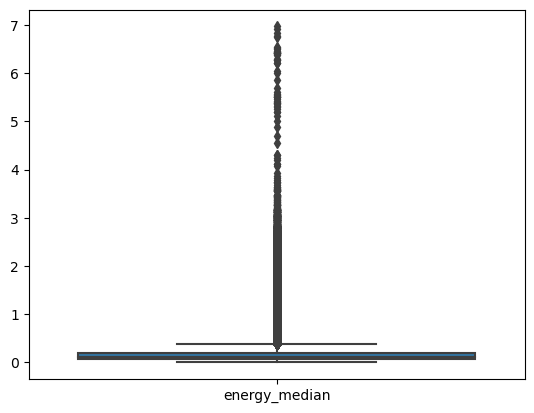

         energy_mean
0           0.154304
1           0.230979
2           0.275479
3           0.213688
4           0.203521
...              ...
3499097     0.179563
3499098     0.091938
3499099     0.251104
3499100     0.117604
3499101     0.086521

[3499102 rows x 1 columns]


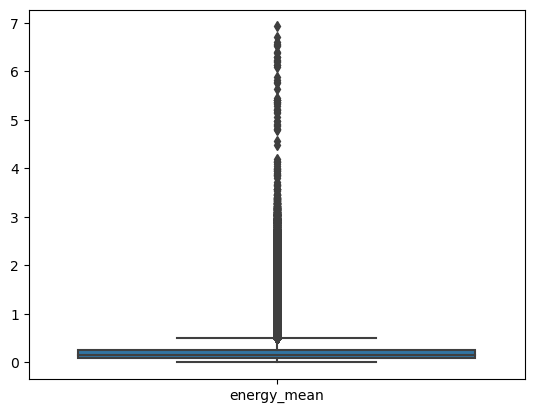

         energy_max
0             0.886
1             0.933
2             1.085
3             1.164
4             0.991
...             ...
3499097       0.759
3499098       0.192
3499099       1.455
3499100       0.554
3499101       0.449

[3499102 rows x 1 columns]


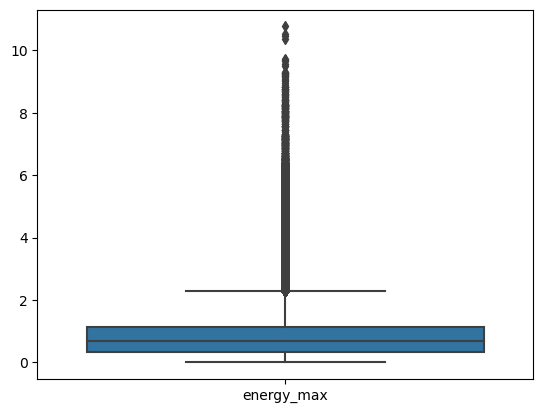

         energy_count
0                  46
1                  48
2                  48
3                  48
4                  48
...               ...
3499097            48
3499098            48
3499099            48
3499100            48
3499101            48

[3499102 rows x 1 columns]


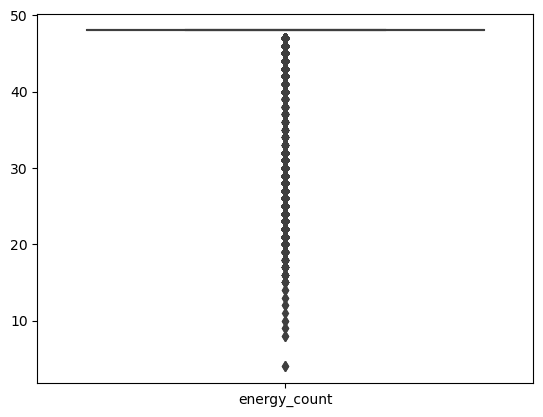

         energy_std
0          0.196034
1          0.192329
2          0.274647
3          0.224483
4          0.184115
...             ...
3499097    0.175669
3499098    0.029466
3499099    0.369093
3499100    0.112632
3499101    0.076162

[3499102 rows x 1 columns]


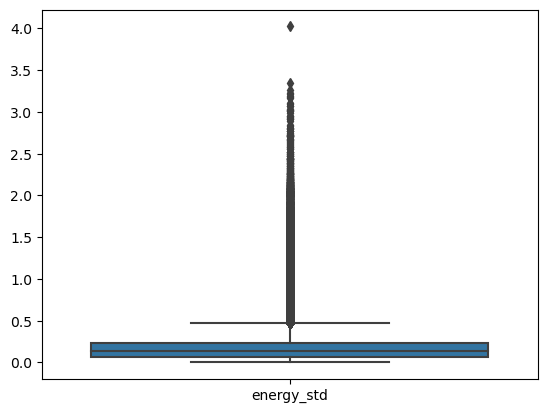

         energy_sum
0             7.098
1            11.087
2            13.223
3            10.257
4             9.769
...             ...
3499097       8.619
3499098       4.413
3499099      12.053
3499100       5.645
3499101       4.153

[3499102 rows x 1 columns]


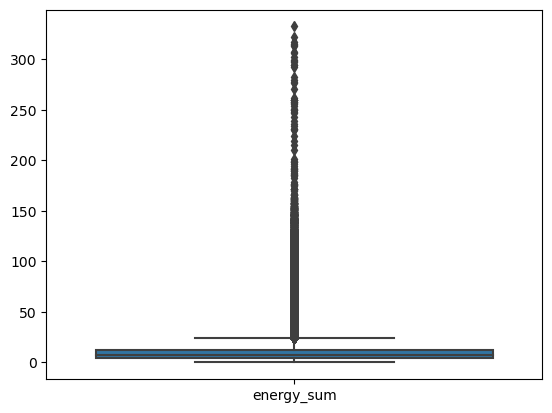

         energy_min
0             0.000
1             0.076
2             0.070
3             0.070
4             0.087
...             ...
3499097       0.048
3499098       0.046
3499099       0.029
3499100       0.031
3499101       0.029

[3499102 rows x 1 columns]


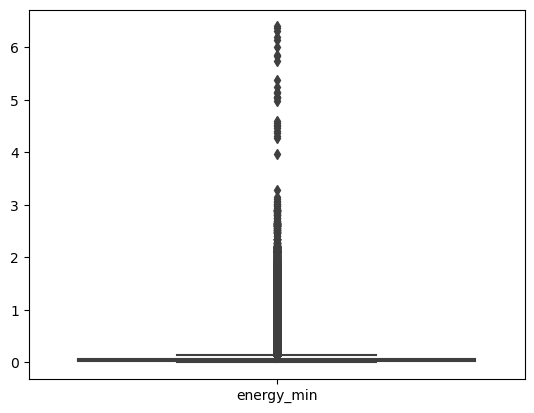

In [12]:
df.show(truncate=15)
# Функция отображения графиков для наблюдения выбросов
def digrams_of_outliers(df):
    print()
    for c in df.columns: 
        column_df = df.select(c).toPandas()
        print(column_df)
        sns.boxplot(column_df)
        plt.show()
digrams_of_outliers(df)

In [ ]:
Количесто выбросов до и после удаления

In [13]:
# Функция получения границ
def get_bounds(df):
    # поиск перцентилей с 0 ошибкой
    bounds = {
    c: dict(
        zip(["q1", "q3"], df.approxQuantile(c, [0.25, 0.75], 0))
    )
    for c in df.columns
    }

    # поиск границ
    for c in bounds:
        iqr = bounds[c]['q3'] - bounds[c]['q1']
        bounds[c]['lower'] = bounds[c]['q1'] - (iqr * 1.5)
        bounds[c]['upper'] = bounds[c]['q3'] + (iqr * 1.5)
    return bounds

# Функция отображения количества выбросов по столбцам
def number_of_outliers(df, bounds):
    
    outliers_table_df = df.select(
    [
        F.when(
            F.col(c).between(bounds[c]['lower'], bounds[c]['upper']), 0
        ).otherwise(1).alias(c+"_out") 
        for c in df.columns
    ])

    outliers_df = outliers_table_df.select([
                        (
                            F.count(F.when((F.col(c)=='1'), c))
                        ).alias(c)
                        for c in outliers_table_df.columns])
    # отображение кол-ва выбросов по столбцам
    outliers_df.show()
bounds = get_bounds(df)

print("Кол-во выбросов по столбцам:")
number_of_outliers(df, bounds)
# Замена выбросов на пропущенные значения
df = df.select(
     *[
        F.when(
             F.col(c).between(bounds[c]['lower'], bounds[c]['upper']), F.col(c)
         ).otherwise(None).alias(c) 
        for c in df.columns
     ]
 )
# Удаление выбросов
df = df.dropna()
print("Кол-во выбросов по столбцам, после удаления выбросов:")
number_of_outliers(df, bounds)

Кол-во выбросов по столбцам:
+-----------------+---------------+--------------+----------------+--------------+--------------+--------------+
|energy_median_out|energy_mean_out|energy_max_out|energy_count_out|energy_std_out|energy_sum_out|energy_min_out|
+-----------------+---------------+--------------+----------------+--------------+--------------+--------------+
|           224973|         201317|        121012|           29750|        158187|        201339|        221460|
+-----------------+---------------+--------------+----------------+--------------+--------------+--------------+

Кол-во выбросов по столбцам, после удаления выбросов:
+-----------------+---------------+--------------+----------------+--------------+--------------+--------------+
|energy_median_out|energy_mean_out|energy_max_out|energy_count_out|energy_std_out|energy_sum_out|energy_min_out|
+-----------------+---------------+--------------+----------------+--------------+--------------+--------------+
|           

In [ ]:
Ящики с усами после удаления выбросов


         energy_median
0               0.1800
1               0.1580
2               0.1310
3               0.1450
4               0.1480
...                ...
3053247         0.1180
3053248         0.0915
3053249         0.0735
3053250         0.0740
3053251         0.0605

[3053252 rows x 1 columns]


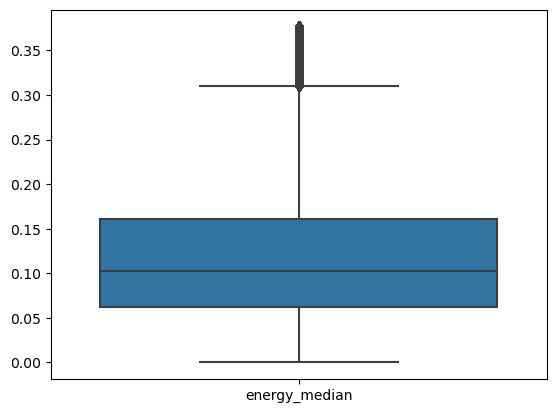

         energy_mean
0           0.230979
1           0.275479
2           0.213688
3           0.203521
4           0.226771
...              ...
3053247     0.179563
3053248     0.091938
3053249     0.251104
3053250     0.117604
3053251     0.086521

[3053252 rows x 1 columns]


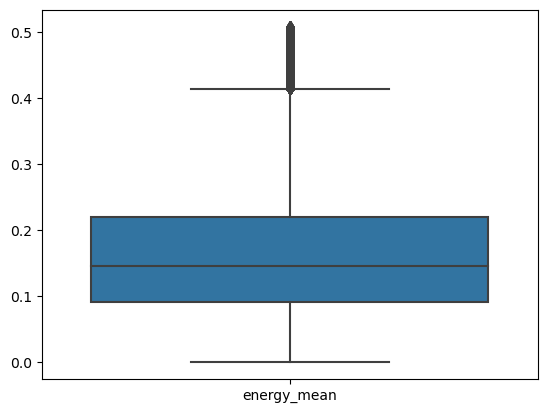

         energy_max
0             0.933
1             1.085
2             1.164
3             0.991
4             0.784
...             ...
3053247       0.759
3053248       0.192
3053249       1.455
3053250       0.554
3053251       0.449

[3053252 rows x 1 columns]


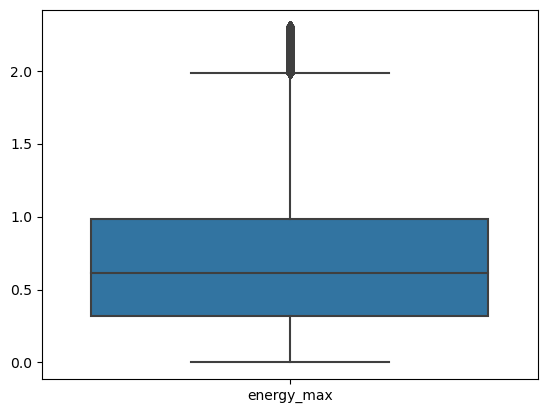

         energy_count
0                  48
1                  48
2                  48
3                  48
4                  48
...               ...
3053247            48
3053248            48
3053249            48
3053250            48
3053251            48

[3053252 rows x 1 columns]


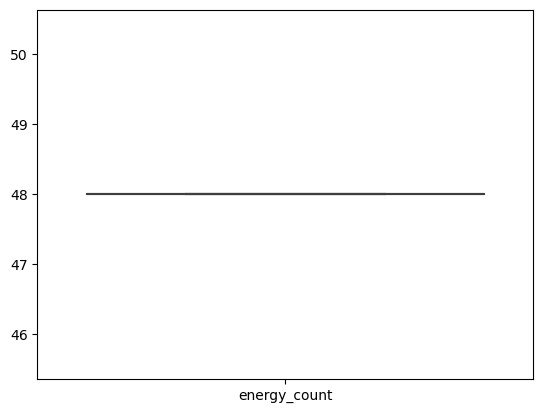

         energy_std
0          0.192329
1          0.274647
2          0.224483
3          0.184115
4          0.184409
...             ...
3053247    0.175669
3053248    0.029466
3053249    0.369093
3053250    0.112632
3053251    0.076162

[3053252 rows x 1 columns]


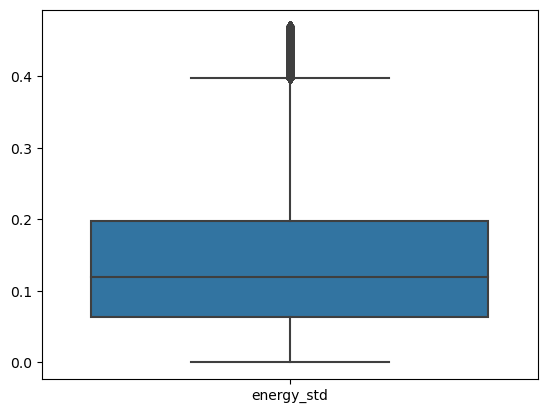

         energy_sum
0            11.087
1            13.223
2            10.257
3             9.769
4            10.885
...             ...
3053247       8.619
3053248       4.413
3053249      12.053
3053250       5.645
3053251       4.153

[3053252 rows x 1 columns]


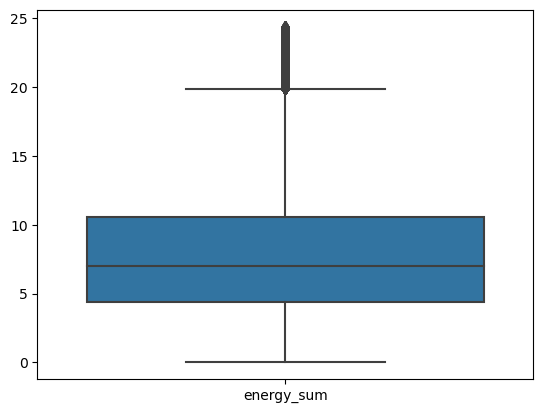

         energy_min
0             0.076
1             0.070
2             0.070
3             0.087
4             0.067
...             ...
3053247       0.048
3053248       0.046
3053249       0.029
3053250       0.031
3053251       0.029

[3053252 rows x 1 columns]


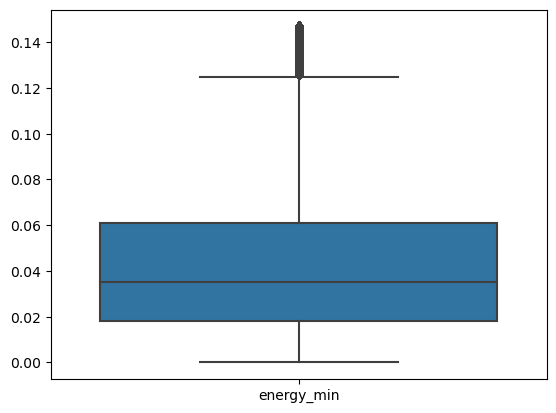

In [14]:
# Отображение графиков после удаления выбросов
digrams_of_outliers(df)

In [ ]:
Матрица корреляции

In [16]:
# Перевести столбцы в векторный вид
assembler = VectorAssembler(
    inputCols=df.columns,
    outputCol="features")
print('До перевода:')
df.show()
print('После перевода:')
output = assembler.transform(df)
output.select("features").show(truncate=False)

# Построение самой матрицы
matrix = Correlation.corr(output, "features").collect()[0][0]

# Перевод матрицы в лист, для дальнейшего правильного отображения
corrmatrix = matrix.toArray().tolist()

# Копия колонок из исходного датасета, для формирования матрицы корреляции
columns = df.columns

# Формированиt матрицы корреляции
df_corr = spark.createDataFrame(corrmatrix, columns)

df_corr.show()

До перевода:
+------------------+------------------+------------------+------------+------------------+------------------+----------+
|     energy_median|       energy_mean|        energy_max|energy_count|        energy_std|        energy_sum|energy_min|
+------------------+------------------+------------------+------------+------------------+------------------+----------+
|              0.18|0.2309791666666667|             0.933|          48|0.1923290055224334|11.087000000000002|     0.076|
|             0.158|0.2754791666666666|             1.085|          48|0.2746472390899211|            13.223|      0.07|
|             0.131|         0.2136875|             1.164|          48|0.2244834407246434|            10.257|      0.07|
|             0.145|0.2035208333333333|             0.991|          48|0.1841152494734004|             9.769|     0.087|
|             0.148|0.2267708333333333|             0.784|          48|0.1844085703901349|10.885000000000002|     0.067|
|             0.166

In [ ]:
Удаление некоррелирующего признака

In [17]:
df = df.drop("energy_count")

In [ ]:
Статистика

In [18]:
removed_df = df.toPandas().describe().astype(float)
removed_df.T

,count,mean,std,min,25%,50%,75%,max
energy_median,3053252.0,0.118768,0.074528,0.0,0.062000,0.103000,0.161000,0.377000
energy_mean,3053252.0,0.163161,0.094318,0.0,0.090979,0.146500,0.220083,0.508542
energy_max,3053252.0,0.695165,0.465291,0.0,0.316000,0.612000,0.983000,2.303000
energy_std,3053252.0,0.140305,0.097866,0.0,0.063570,0.118744,0.197008,0.469602
energy_sum,3053252.0,7.831735,4.527253,0.0,4.367000,7.032000,10.564000,24.410000
energy_min,3053252.0,0.042886,0.032184,0.0,0.018000,0.035000,0.061000,0.147000


In [ ]:
Гистограммы

array([[<AxesSubplot: title={'center': 'energy_median'}>,
        <AxesSubplot: title={'center': 'energy_mean'}>],
       [<AxesSubplot: title={'center': 'energy_max'}>,
        <AxesSubplot: title={'center': 'energy_std'}>],
       [<AxesSubplot: title={'center': 'energy_sum'}>,
        <AxesSubplot: title={'center': 'energy_min'}>]], dtype=object)

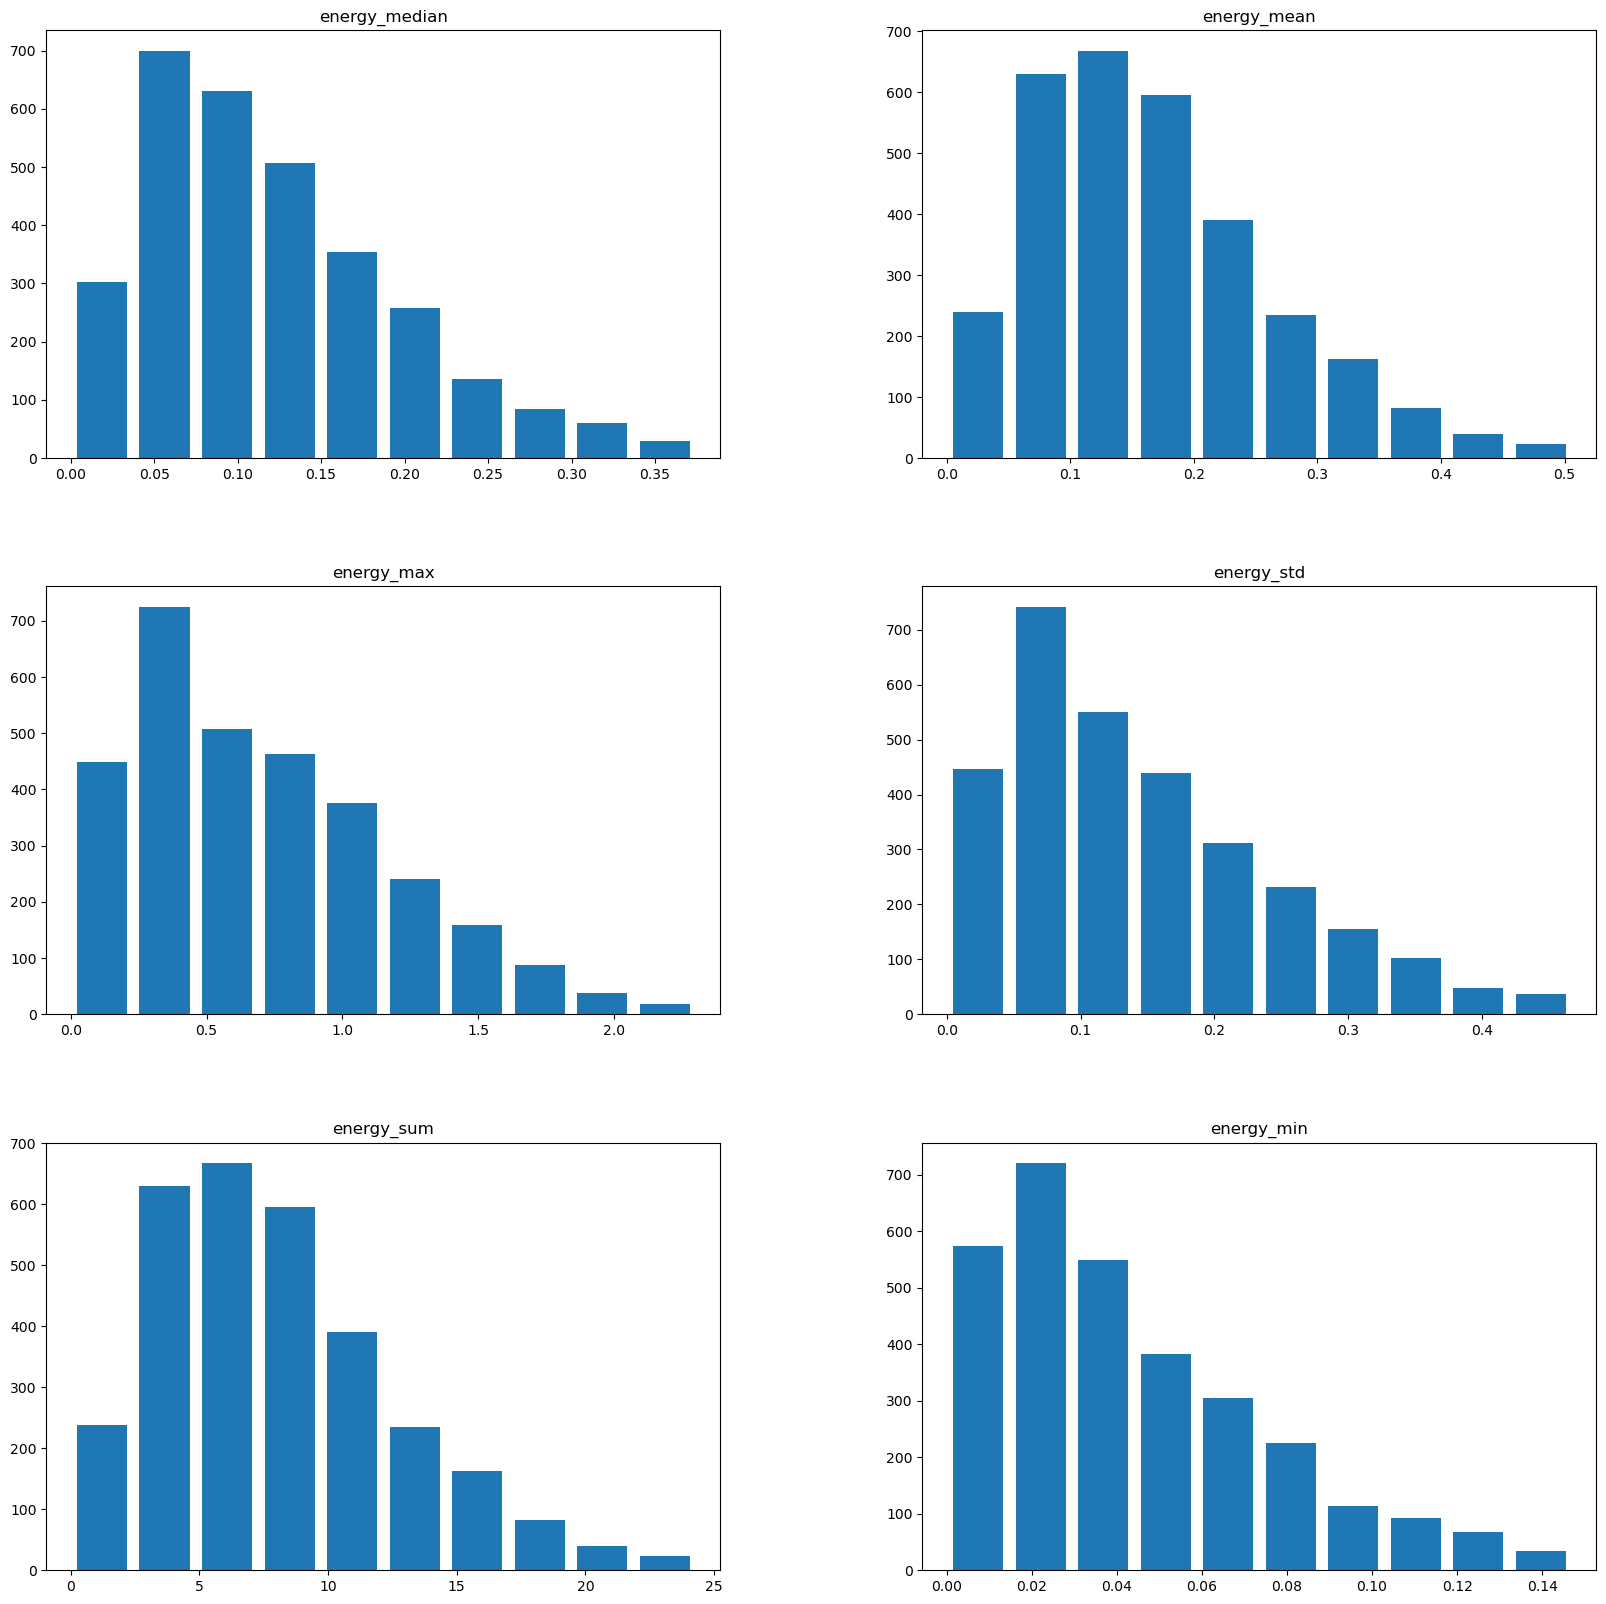

In [19]:
New_df = df.sample(True, 0.001, seed=42)
New_df = New_df.toPandas()
New_df.hist(figsize = (20,20), grid = False, rwidth = 0.8)

In [ ]:
Сохранение очищенного датасета

In [20]:
df.toPandas().to_csv('Data/cleared_df.csv', index=False)